In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import unidecode
import nltk 
from tqdm import tqdm

from wordcloud.wordcloud import STOPWORDS, WordCloud
from spacy.lang.pt.stop_words import STOP_WORDS

from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#!pip install spacy
#!pip install wordcloud
#!pip install nltk

In [3]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download pt_core_news_sm

In [4]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [5]:
viagem_df = pd.read_csv("2022_Viagem.csv", sep=";", encoding="latin-1")
viagem_df.head(10)

,Identificador do processo de viagem,Número da Proposta (PCDP),Situação,Viagem Urgente,Justificativa Urgência Viagem,Código do órgão superior,Nome do órgão superior,Código órgão solicitante,Nome órgão solicitante,CPF viajante,...,Função,Descrição Função,Período - Data de início,Período - Data de fim,Destinos,Motivo,Valor diárias,Valor passagens,Valor devolução,Valor outros gastos
0,17438343,000001/22,Realizada,NÃO,Sem informação,35000,Ministério das Relações Exteriores,35000,Ministério das Relações Exteriores - Unidades ...,***.188.261-**,...,-1,Não Informado,12/02/2022,14/02/2022,Brasília/DF,Servidor designado em missão transitória na Em...,"0,00","0,00","0,00","0,00"
1,17503013,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID012100276,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,24/04/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"20995,16","0,00","0,00","0,00"
2,17503072,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID006700175,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,04/11/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"63045,68","0,00","0,00","0,00"
3,17503094,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID005400135,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,08/09/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"49353,83","0,00","0,00","0,00"
4,17513261,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID214200100,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,29/08/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"36225,93","0,00","0,00","0,00"
5,17513655,000001/22,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26352,Fundação Universidade Federal do ABC,***.509.067-**,...,-1,Não Informado,04/01/2022,16/12/2022,Londres/Reino Unido,Realização de pós-doutorado na London School o...,"0,00","0,00","0,00","0,00"
6,17538368,005154/22,Realizada,SIM,Devido a urgência da demanda.,49000,Ministério do Desenvolvimento Agrário,22201,Instituto Nacional de Colonização e Reforma Ag...,***.580.462-**,...,-1,Não Informado,08/08/2022,13/08/2022,Belterra/PA,Realizar atividades relacionadas à implementaç...,"1550,85","0,00","0,00","0,00"
7,17563956,000002/22-2C,Realizada,SIM,realização de coletas das amostras biológicas ...,44000,Ministério do Meio Ambiente,44207,Instituto Chico Mendes de Conservação da Biodi...,***.450.349-**,...,-1,Não Informado,07/02/2022,12/02/2022,Fernando de Noronha/PE,Participar da realização de coletas das amostr...,"964,40","6919,20","0,00","0,00"
8,17564009,000001/22-2C,Realizada,SIM,realização de coletas das amostras biológicas ...,44000,Ministério do Meio Ambiente,44207,Instituto Chico Mendes de Conservação da Biodi...,***.011.204-**,...,-1,Não Informado,07/02/2022,11/02/2022,Fernando de Noronha/PE,Participar da realização de coletas das amostr...,"891,50","7561,20","0,00","0,00"
9,17569036,000002/22-3C,Realizada,SIM,Não há.,35000,Ministério das Relações Exteriores,35000,Ministério das Relações Exteriores - Unidades ...,***.272.667-**,...,FGR-1,FGR-1,06/03/2022,07/03/2022,Brasília/DF,Servidor designado em missão transitória na Em...,"0,00","2801,39","0,00","0,00"


In [6]:
viagem_df.columns = ["id_viagem", "numero_proposta", "situacao", "viagem_urgente", "justificativa_urgencia_viagem",
                     "codigo_orgao_superior", "nome_orgao_superior", "codigo_orgao_solicitante", "nome_orgao_solicitante",
                     "cpf_viajante", "nome", "cargo", "funcao", "descricao_funcao",
                     "data_inicio", "data_fim", "destinos", "motivo", "valor_diarias",
                     "valor_passagens", "valor_devolucao", "valor_outros_gastos"]

# convert valores to float
viagem_df["valor_diarias"] = viagem_df["valor_diarias"].str.replace(",", ".").astype(float)
viagem_df["valor_passagens"] = viagem_df["valor_passagens"].str.replace(",", ".").astype(float)
viagem_df["valor_devolucao"] = viagem_df["valor_devolucao"].str.replace(",", ".").astype(float)
viagem_df["valor_outros_gastos"] = viagem_df["valor_outros_gastos"].str.replace(",", ".").astype(float)


In [7]:
viagem_df[viagem_df["viagem_urgente"] == "SIM"]["justificativa_urgencia_viagem"]

6                             Devido a urgência da demanda.
7         realização de coletas das amostras biológicas ...
8         realização de coletas das amostras biológicas ...
9                                                   Não há.
42                                       Conforme portaria.
                                ...                        
647308                                Conforme O.S em anexo
647309                                Conforme O.S em anexo
647310                      VIAGEM CONFIRMADA FORA DO PRAZO
647311                    CONFORME O.S. 4998/2022 EM ANEXO.
647312                    CONFORME O.S. 5104/2022 EM ANEXO.
Name: justificativa_urgencia_viagem, Length: 386721, dtype: object

In [17]:
justificativas = viagem_df[viagem_df["viagem_urgente"] == "SIM"]["justificativa_urgencia_viagem"]
justificativas.reset_index(drop=True, inplace=True)
print(len(justificativas))
justificativas.head(10)

386721


0                        Devido a urgência da demanda.
1    realização de coletas das amostras biológicas ...
2    realização de coletas das amostras biológicas ...
3                                              Não há.
4                                   Conforme portaria.
5                                   Conforme portaria.
6                                   Conforme portaria.
7                                   Conforme portaria.
8                          Conforme portaria em anexo.
9                                Alteração de bilhete.
Name: justificativa_urgencia_viagem, dtype: object

# Pré-Processamento de Texto

In [18]:
wl = WordNetLemmatizer()

def obter_stopwords():
    stopwords = []
        
    stopwords.extend([unidecode.unidecode(palavra.lower().replace(" ", "")) for palavra in nltk.corpus.stopwords.words('portuguese')])
    stopwords.extend([unidecode.unidecode(palavra.lower().replace(" ", "")) for palavra in STOPWORDS])
    stopwords.extend([unidecode.unidecode(word.lower().replace(" ", "")) for word in STOP_WORDS])
        
    stopwords = list(set(stopwords))
    stopwords.sort()
    
    return stopwords

# remove todos stopwords no texto
def remocao_stopwords(string):
    
    stopwords = obter_stopwords()
    texto_limpo = [i for i in string.split() if i not in stopwords]
    
    return ' '.join(texto_limpo)

# remove textos desnecessários como pontuação, números, caracteres especiais e URLs no texto
def limpeza_texto(text):
    text = unidecode.unidecode(str(text).lower().strip()) 
    text= re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=  re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub("@\S+", "", text)
    text = re.sub("\$", "", text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    text = re.sub("#", "", text)
    text = re.sub(r'https?:\/\/[\r\n],"[\r\n]"', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]',' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub('[^a-zà-ù ]', ' ', text)
    return text

 
# classificar token em categoria gramatica 
def obter_pos_tag(token):
    if token.startswith('J'):
        return wordnet.ADJ
    elif token.startswith('V'):
        return wordnet.VERB
    elif token.startswith('N'):
        return wordnet.NOUN
    elif token.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# coverte palavras em sua forma canônica, conhecida como "lema"
def lematizacao(string):
    token =word_tokenize(string)
    word_pos_tags = nltk.pos_tag(token) # classificação da classe gramatica do token ("agora" ,"RV")
    texto_limpo =[wl.lemmatize(tag[0], obter_pos_tag(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(texto_limpo)

# Função para realizar a stemização em uma palavra
def stemmer(word):
    # Inicializar o stemmer
    stemmer = SnowballStemmer('portuguese')
    return stemmer.stem(word)

In [10]:
# procedimento demorado depedendo do tamanho da base de dados
# então feito somente uma unica vez no projeto 
def pre_processamento_texto(texto):
    texto = limpeza_texto(texto)
    texto = remocao_stopwords(texto)
    texto = lematizacao(texto)
    return texto

In [19]:
tqdm.pandas()
justificativas_limpo = justificativas.progress_apply(lambda x: pre_processamento_texto(str(x)))

100%|██████████| 386721/386721 [15:41<00:00, 410.54it/s] 


In [22]:
justificativas_limpo.head(20)

0                               devido urgencia demanda
1     realizacao coletas amostras biologicas fernand...
2     realizacao coletas amostras biologicas fernand...
3                                                      
4                                     conforme portaria
5                                     conforme portaria
6                                     conforme portaria
7                                     conforme portaria
8                               conforme portaria anexo
9                                     alteracao bilhete
10                recursos diarias descentralizados vgm
11    proposta cadastrada retornou devido impossibil...
12    proposta cadastrada retornou devido impossibil...
13    proposta cadastrada retornou devido impossibil...
14    proposta cadastrada retornou devido impossibil...
15    proposta cadastrada retornou devido impossibil...
16    proposta cadastrada retornou devido impossibil...
17    proposta cadastrada retornou devido imposs

In [23]:
def plot_word_cloud(counter):
    stopwords = obter_stopwords()
    # create the wordcloud object
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color='white', max_font_size=150, max_words=800,
                          min_font_size=1, collocation_threshold=2, collocations=False).generate_from_frequencies(counter)

    # plot the wordcloud object
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud', fontsize=20)
    plt.show()

In [24]:
def plot_barh(counter, top=10):
    colorblind = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#56B4E9"]
    most_common = counter.most_common(top)
    fig, ax = plt.subplots(figsize=(20, 10))
    keys = [key for key, count in most_common]
    counts = [count for key, count in most_common]
    plt.barh(keys, counts, color=colorblind[0])
    ax.bar_label(ax.containers[0])

    ax.grid(axis='x')
    ax.set_xlabel("Count")
    ax.set_ylabel("Word")
    ax.invert_yaxis()
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    plt.title(f'Most Frequently Words - Top {top}', fontsize=20)
    plt.show()

In [25]:
counter_words = Counter()
words = justificativas_limpo.astype(str).tolist()
words = [i for i in words if i != 'nan']
words = [i for i in words if i != '']
words = ' '.join(words)
counter_words.update(word_tokenize(words))
counter_words

Counter({'viagem': 80598,
         'conforme': 69194,
         'dia': 66011,
         'prazo': 49359,
         'data': 46783,
         'devido': 46170,
         'necessidade': 42236,
         'solicitacao': 39708,
         'diarias': 33053,
         'missao': 28625,
         'oficio': 25892,
         'autorizacao': 25847,
         'anexo': 25843,
         'antecedencia': 23118,
         'servico': 20886,
         'passagens': 17947,
         'evento': 16024,
         'autorizado': 15285,
         'processo': 15132,
         'periodo': 15029,
         'operacao': 14539,
         'deslocamento': 14407,
         'agenda': 14122,
         'justifica': 13935,
         'servidor': 13468,
         'sendo': 13274,
         'realizacao': 13157,
         'confirmacao': 12954,
         'urgente': 12591,
         'cronograma': 12570,
         'coordenacao': 12073,
         'realizar': 12029,
         'tendo': 11814,
         'urgencia': 11766,
         'planejamento': 11461,
         'tecnica': 11

In [26]:
counter_phrases = Counter()
phrases = justificativas_limpo.astype(str).tolist()
phrases = [i for i in phrases if i != 'nan']
phrases = [i for i in phrases if i != '']
counter_phrases.update(phrases)
counter_phrases

Counter({'conforme autorizado oficio': 6054,
         'necessidade servico': 5095,
         'conforme autorizacao oficio': 4505,
         'melhor voo atende operacao acolhida': 4396,
         'caso': 3972,
         'diarias passagens nacionais coletivo cad diop autorizado oficio': 3616,
         'conforme necessidade missao': 2838,
         'acordo aumento volume trabalho deficit acentuado efetivo coordenacao gestao efetivo coge conforme exposto nota tecnica': 2338,
         'missao transporte autoridade sc': 2189,
         'conforme anexo': 2176,
         'periodo definido coordenacao viagem': 2113,
         'informo sr ordem servico confeccionada prazo superior dia antecedem missao': 2027,
         'devido tramites administrativos razao alteracoes ocorridas decreto': 1918,
         'devido dinamica complexidade acoes envolvem atividade inspecao voo inviavel planejamento missoes antecedencia superior dia': 1599,
         'extemporaneidade solicitacao pagamento diarias justifica curto 

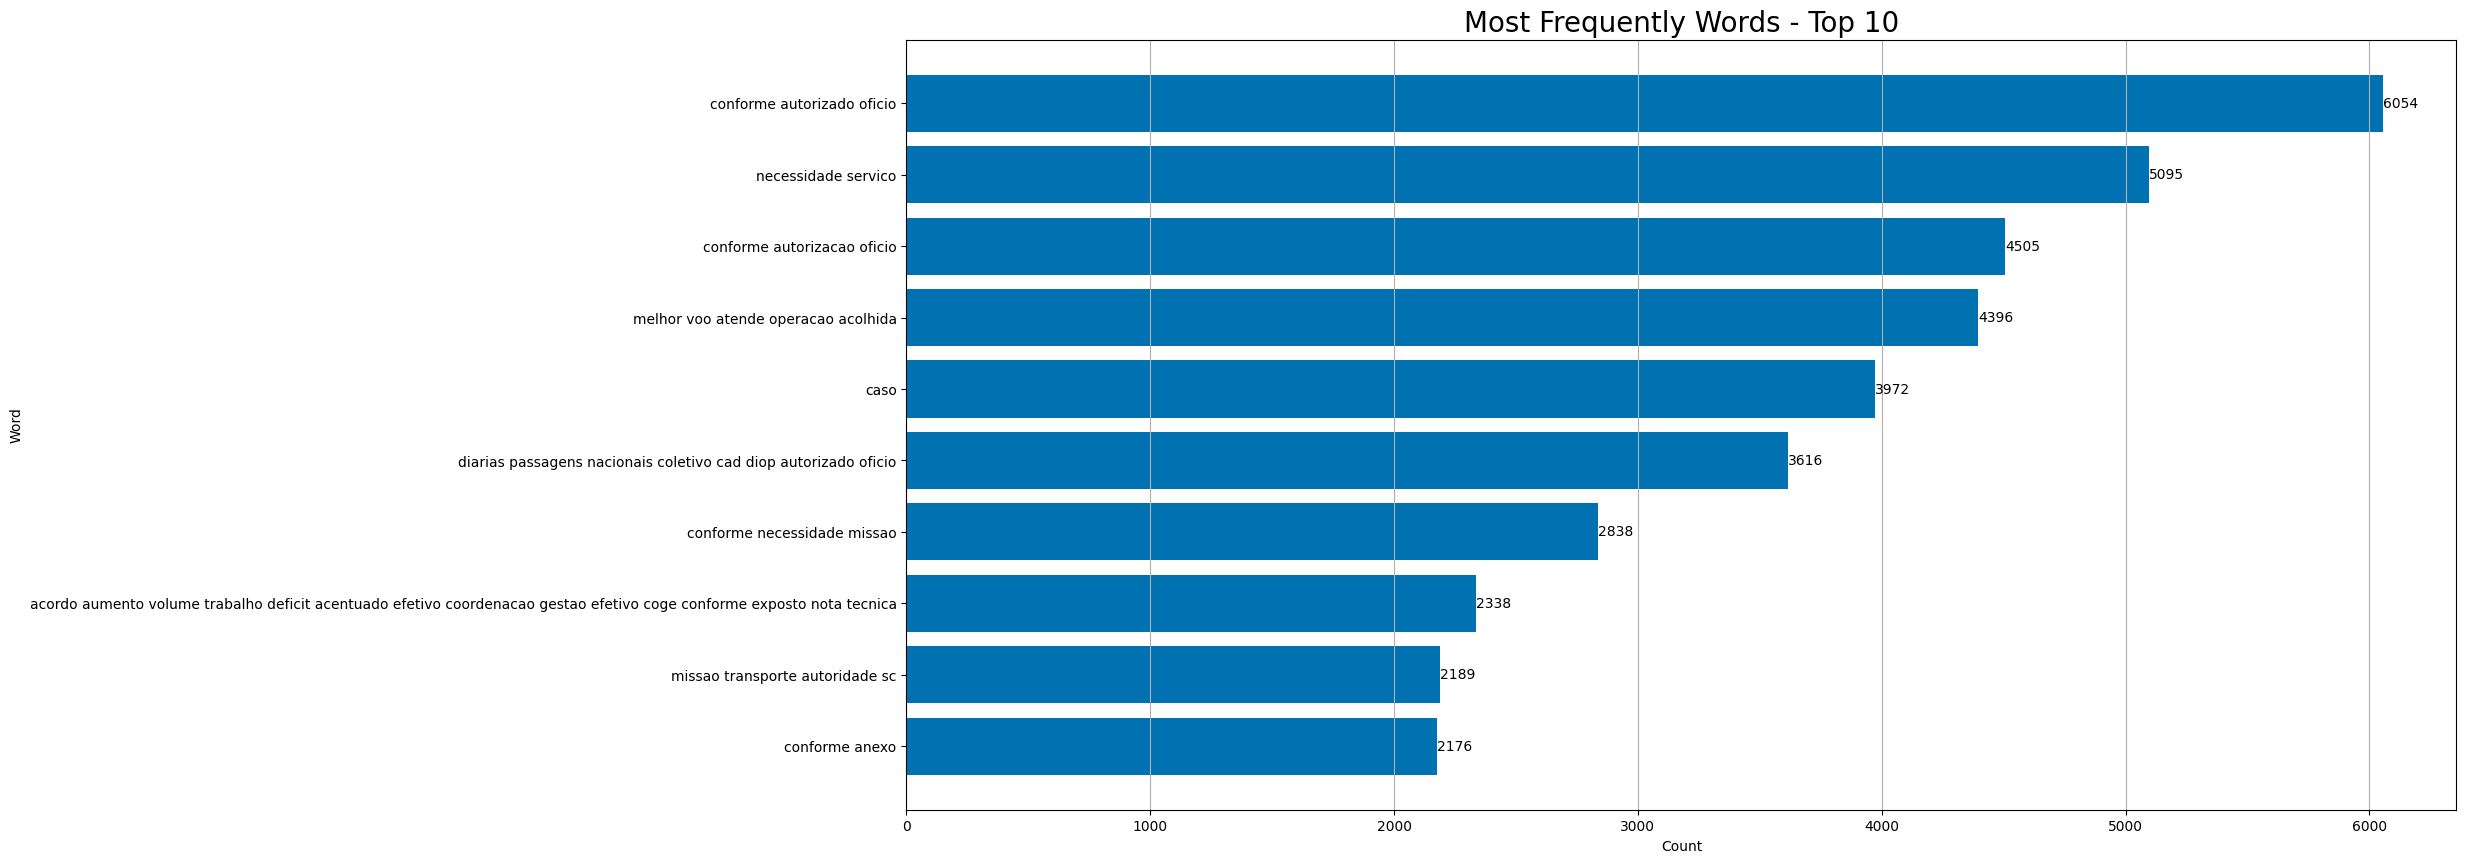

In [27]:
plot_barh(counter_phrases, top=10)

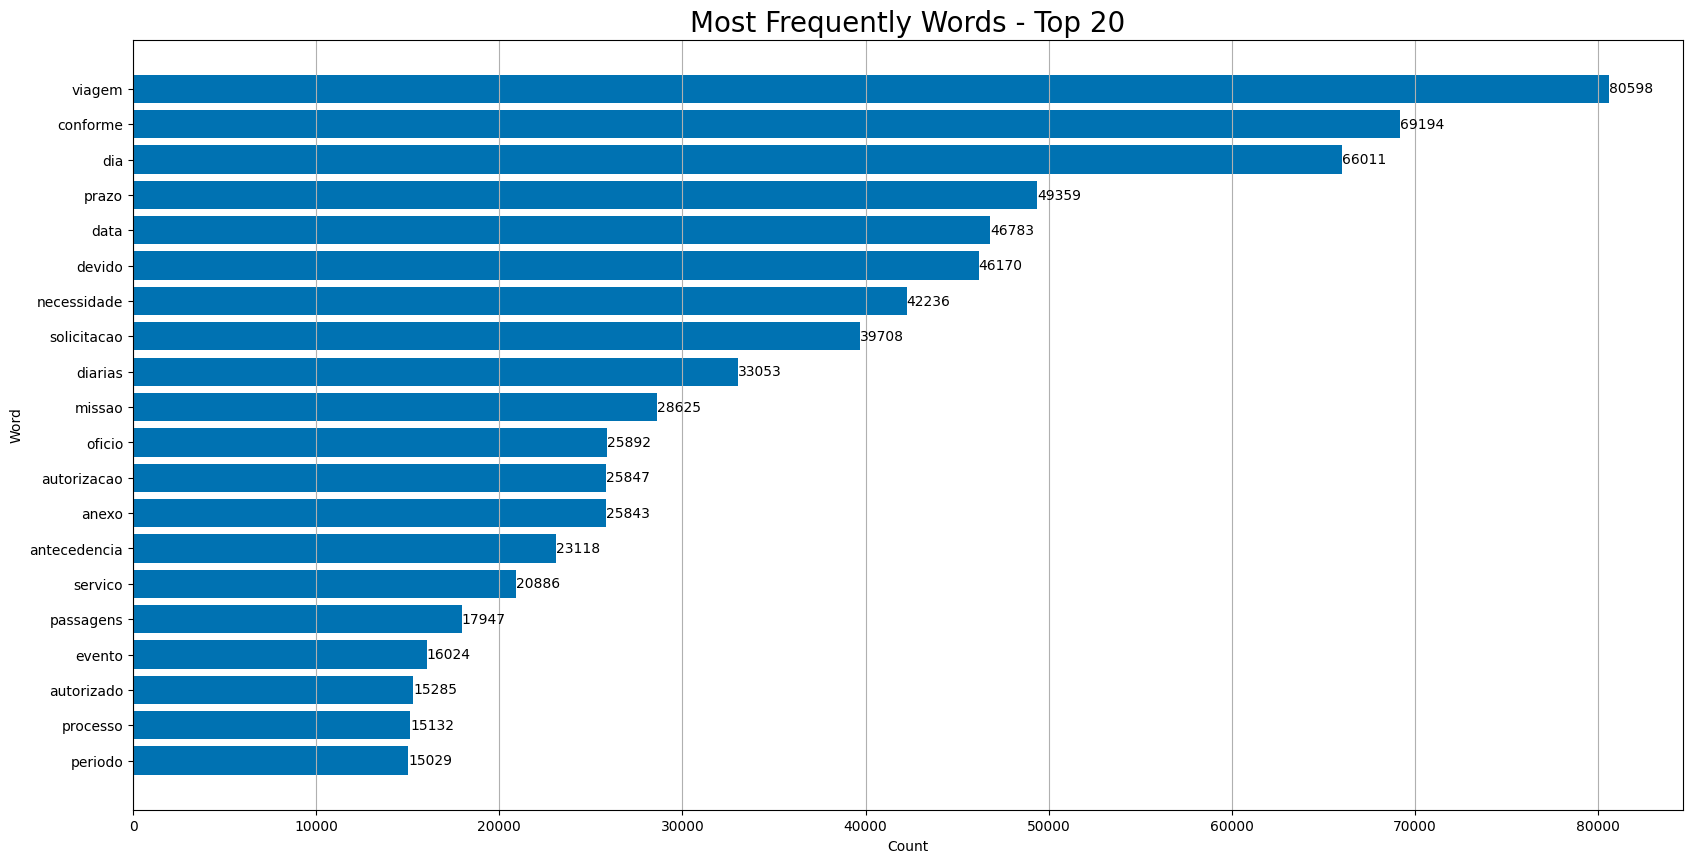

In [28]:
plot_barh(counter_words, top=20)

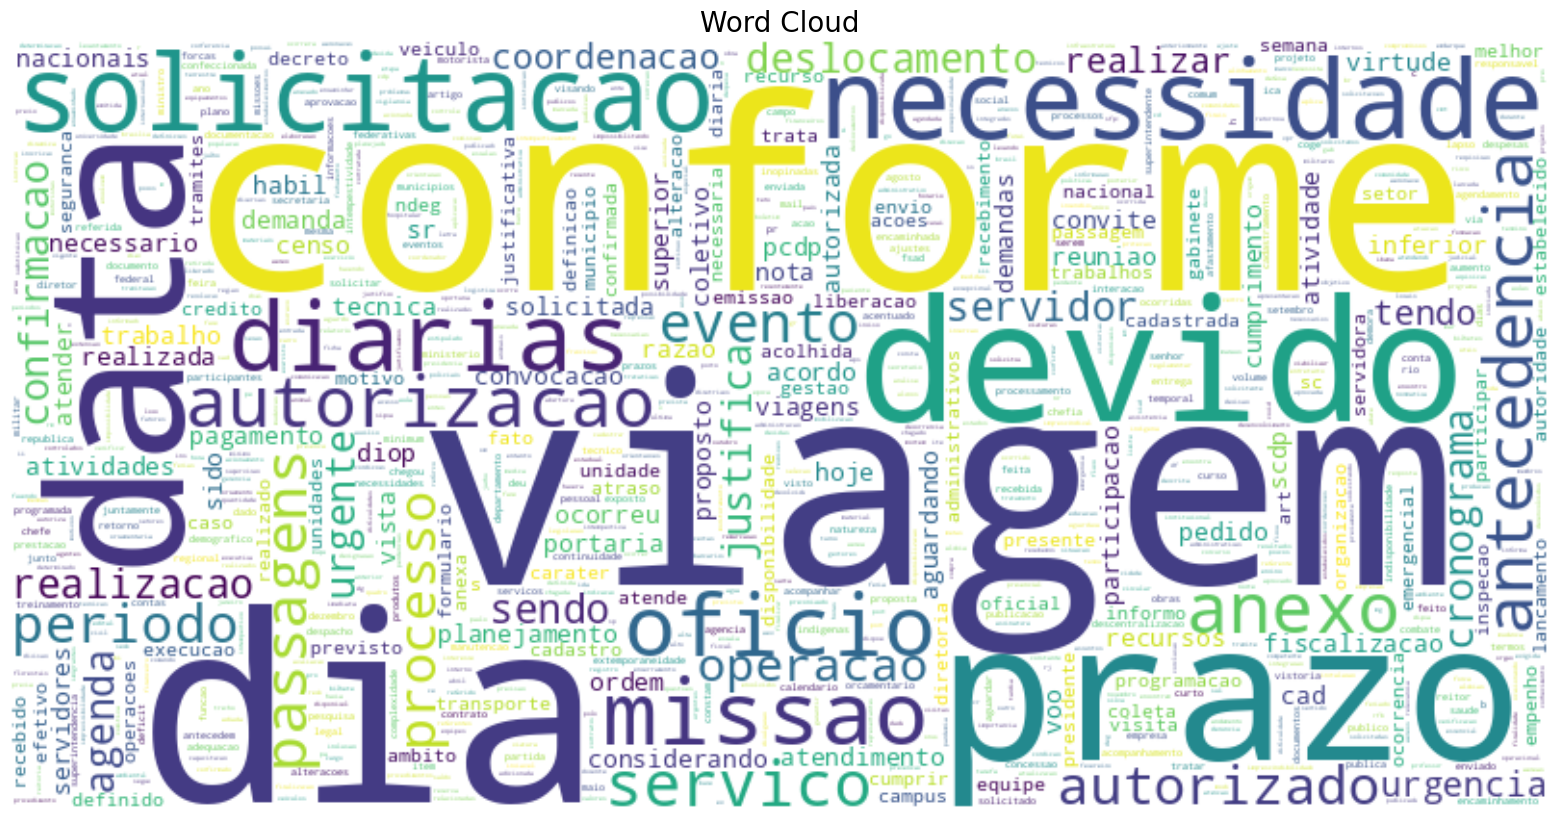

In [29]:
plot_word_cloud(counter_words)

In [35]:
justificativas_limpo = justificativas_limpo.replace('', np.nan)
justificativas_limpo = justificativas_limpo.dropna()

In [36]:
justificativas_limpo.to_csv('2022_Urgencia_texto_limpo.csv', sep=";", encoding="latin-1", index=False)